#                                                       Analyse préliminaire des données
Maamar,Asma,Richard

In [1]:
import numpy as np
from itertools import product
import time, tracemalloc,gc
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gc.collect()
# === Initialisation ===
X_dict = {} # Dictionnaire qui contiendra les images
results = []  # dictionnaire pour stocker temps et mémoire
df_dict ={} # stocke les reférences des dataframes

# Pour les tests, nous avons utilisé le dossier suivant pour réaliser l'expérience sur de petits échantillons.
classes = {0: ("Normal/images", "Normal/masks")}  # un seul dossier

#Visualisation l'evolution de la memoire,stockage, temps d'execution par rapport à différents lot d'images (1000,2000,4000,6000)
for lot in [1000,2000,4000,6000]:
    X_dict[lot]={}
    df_dict[lot]={}
    #results[lot]={}
    #Création tableau numpy selon le nombre d'images pour pré-allocation de la memoire
    taille =[128,150,200,299]
    for size in taille:
        X_dict[lot][size]= np.zeros((lot,size*size), dtype=np.uint8)

for lot, taille in product([1000,2000,4000,6000], [128, 150, 200, 299]):
    tracemalloc.start()
    start_time= time.time()
    for indice ,(img,mask) in classes.items():
        contenu_image=os.listdir(img)
        contenu_mask=os.listdir(mask)
        compteur_fichier=0
        for i,(imag,masks) in enumerate(zip(contenu_image,contenu_mask)):
            # Lecture et redimension
            img_covid4=cv2.imread(os.path.join(img,imag),cv2.IMREAD_GRAYSCALE)
            img_resize=cv2.resize(img_covid4,dsize=(taille,taille))
            mask_covid4=cv2.imread(os.path.join(mask,masks),cv2.IMREAD_GRAYSCALE)
            mask_resize=cv2.resize(mask_covid4,dsize=(taille,taille))
            # Fusion
            melange_covid4=cv2.bitwise_and(img_resize,mask_resize)
            #rempli X_dict pour chaque image à la taille 
            X_dict[lot][taille][i,:] = melange_covid4.reshape(-1)
            compteur_fichier =compteur_fichier +1
            if compteur_fichier == lot:
                break
                
    # Création du DataFrame après avoir rempli toutes les images
    df_dict[lot][taille]= pd.DataFrame(X_dict[lot][taille])
    #Suppression des colonnes inutiles
    df_dict[lot][taille]=df_dict[lot][taille].loc[:,(df_dict[lot][taille] != 0).any(axis=0)]
    
    # Mémoire et temps
    current,peak= tracemalloc.get_traced_memory()
    end_time = time.time() - start_time
    tracemalloc.stop()
    gc.collect()
    time.sleep(1)
    
    #On recupere les infos
    mem=round(int(df_dict[lot][taille].memory_usage(deep=True).sum())/(1024**2),3)
    Col=df_dict[lot][taille].shape[1]
    img=df_dict[lot][taille].shape[0]
    temps=f"{end_time:0.3f}"
    pic=f"{(peak/(1024**2)):.3f}"
    #results[lot][taille] = {"Pic Mémoire":pic,"Execution(s)":temps,"Colonne Pixel":Col,"stockage (Mo)":mem}
    results.append({"lot":lot,"Echantillon": taille,"Pic Mémoire (Mo)":pic,"Execution(s)":temps,"Ligne (Nb Images)":img,"Colonne Pixel":Col,"stockage (Mo)":mem})

df_info=pd.DataFrame.from_dict(results)

## Tableau 1 : Impact du nombre d’images et de la taille des pixels sur la mémoire et le stockage


**Légende :**  
- **Pic Mémoire (Mo)** : mémoire maximale utilisée pendant le traitement  
- **Execution (s)** : durée d’exécution en secondes  
- **Ligne (Nb Images)** et **Colonne Pixel** : dimensions de la matrice/images  
- **Stockage (Mo)** : mémoire totale occupée par les données

In [3]:
df_info.set_index(["lot","Echantillon"])

Pic Mémoire (Mo) Execution(s)  Ligne (Nb Images)  \
lot  Echantillon                                                    
1000 128                   28.102        1.405               1000   
     150                   38.122        1.326               1000   
     200                   66.488        1.369               1000   
     299                  146.719        1.508               1000   
2000 128                   58.834        2.515               2000   
     150                   80.161        2.712               2000   
     200                  141.192        2.759               2000   
     299                  313.462        3.000               2000   
4000 128                  118.782        5.100               4000   
     150                  162.418        5.103               4000   
     200                  287.195        5.441               4000   
     299                  639.463        5.922               4000   
6000 128                  177.676        7.617               6000   
     150                  243.462        7.756               6000   
     200                  430.878        8.087               6000   
     299                  959.698        8.780               6000   

                  Colonne Pixel  stockage (Mo)  
lot  Echantillon                                
1000 128                  13544         12.917  
     150                  18657         17.793  
     200                  33122         31.588  
     299                  74038         70.608  
2000 128                  14748         28.130  
     150                  20301         38.721  
     200                  36086         68.829  
     299                  80642        153.813  
4000 128                  15195         57.964  
     150                  20895         79.708  
     200                  37141        141.682  
     299                  82988        316.574  
6000 128                  15253         87.278  
     150                  20976        120.026  
     200                  37280        213.318  
     299                  83284        476.555

On constate que l’augmentation de la taille des pixels entraîne une hausse significative 
de la mémoire utilisée ainsi que du stockage des données.

In [4]:
# Conversion en float pour visualisation des données
df_info=df_info.astype(float)
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lot                16 non-null     float64
 1   Echantillon        16 non-null     float64
 2   Pic Mémoire (Mo)   16 non-null     float64
 3   Execution(s)       16 non-null     float64
 4   Ligne (Nb Images)  16 non-null     float64
 5   Colonne Pixel      16 non-null     float64
 6   stockage (Mo)      16 non-null     float64
dtypes: float64(7)
memory usage: 1.0 KB


# Évolution du stockage selon le lot et la taille des pixels

Ce graphique montre comment **le stockage en mémoire (Mo)** varie en fonction du **lot d'images** et de la **taille des pixels**.  
Chaque **courbe colorée** correspond à un **lot différent**, et on peut observer que plus le nombre d’images dans le lot est élevé, plus la mémoire utilisée et le stockage augmentent.

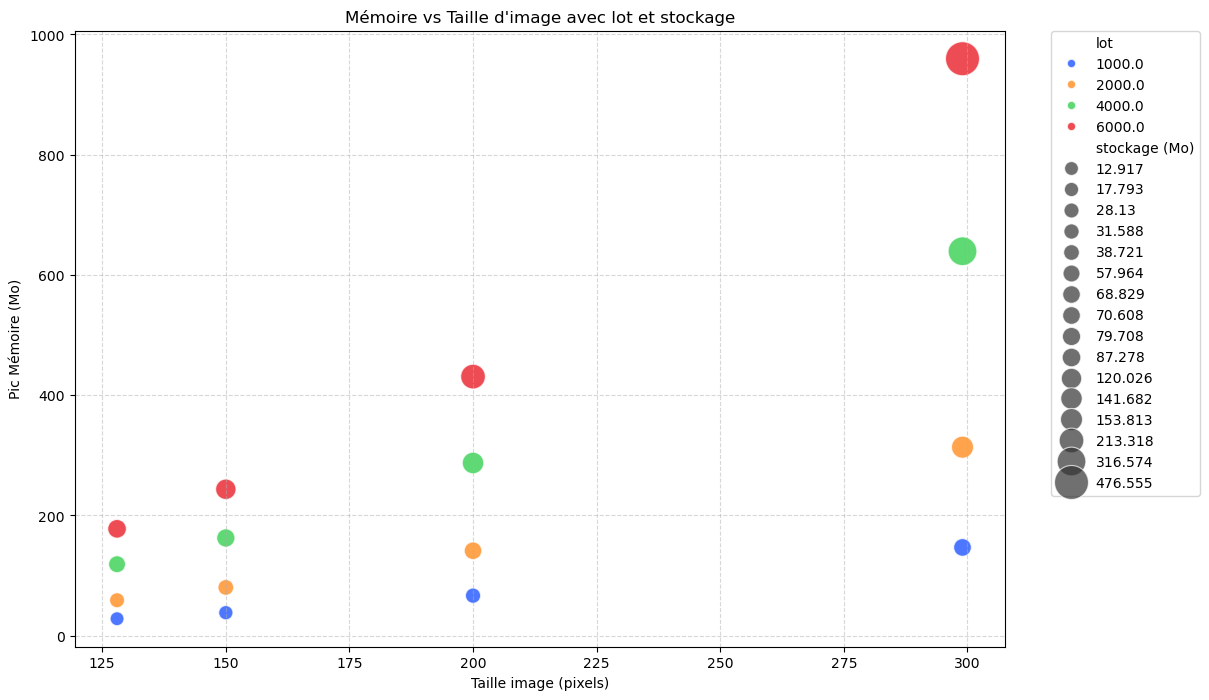

In [5]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_info,
    x="Echantillon", 
    y="Pic Mémoire (Mo)",
    hue="lot",               # couleur selon lot
    size="stockage (Mo)",    # taille du point selon stockage
    sizes=(100, 600),         # taille min et max des points
    alpha=0.7,               # transparence
    palette="bright",
    legend="full"
)

plt.title("Mémoire vs Taille d'image avec lot et stockage")
plt.xlabel("Taille image (pixels)")
plt.ylabel("Pic Mémoire (Mo)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Après analyse du jeu de données, on peut anticiper que les performances du modèle d’apprentissage seront influencées par la taille des images.
En effet, plus la résolution (nombre de pixels) augmente, plus la consommation mémoire et le temps de calcul nécessaires au traitement et à l’entraînement 
du modèle risquent d’augmenter.
Il serait donc pertinent de créer plusieurs datasets correspondant à différentes tailles d’images, afin de comparer les performances du modèle 
et déterminer si la résolution a un impact significatif sur la précision et l’efficacité du modèle.